In [1]:
from medmnist import VesselMNIST3D
from fastMONAI.vision_all import *
import numpy as np
import pandas as pd
from fastai.vision.all import *
from PIL import Image
import matplotlib.pyplot as plt
import os
import nibabel as nib

In [2]:
#Download
dir = '../data/vesselmnist3d'
if not os.path.exists(dir):
    os.makedirs(dir)
dataset = VesselMNIST3D(split="train", download=True, root=dir)

Using downloaded and verified file: ../data/vesselmnist3d\vesselmnist3d.npz


In [3]:
npz = np.load(dir + "/vesselmnist3d.npz")

In [4]:
a = npz['train_images'][0]
a.shape

(28, 28, 28)

In [5]:
#Trust me, i have no idea what i am doing
affine = array([
  [1,0,0,1],
  [0,1,0,1],
  [0,0,1,1],
  [0,0,0,1]
])


In [6]:
npz.files

['train_images',
 'train_labels',
 'val_images',
 'val_labels',
 'test_images',
 'test_labels']

In [7]:
#save a matrise as a .nii.gz file
def saveAsNiiGz(dir, mat, affine, folderName, index):
    newNiiGz = nib.Nifti1Image(mat, affine=affine)
    nib.save(newNiiGz, dir + "/" + folderName + "/" + str(index) + ".nii.gz")
# saveAsNiiGz(dir, a, affine, "test", 1)

In [8]:
#Create files and dataframe
def createDataFrame(dir, folderType, affine):
    df = pd.DataFrame(columns=["filePath", "label"])
    length = len(npz[folderType + '_images'])
    if not os.path.exists(dir + "/" + folderType):
        os.makedirs(dir + "/" + folderType)
    for i in range(length):
        saveAsNiiGz(dir, npz[folderType + "_images"][i], affine, folderType, i)
        df = df.append({"filePath": dir + "/" + folderType + "/" + str(i) + ".nii.gz", "label": npz[folderType + '_labels'][i][0]}, ignore_index=True)

    return df
# df = createDataFrame(dir, "train", affine)        

In [9]:
#get dataframe
def getDataFrame(dir, folderType):
    df = pd.DataFrame(columns=["filePath", "label"])
    length = len(npz[folderType + '_images'])
    for i in range(length):
        df = df.append({"filePath": dir + "/" + folderType + "/" + str(i) + ".nii.gz", "label": npz[folderType + '_labels'][i][0]}, ignore_index=True)
    return df
df = getDataFrame(dir, "train")

In [10]:
df

,filePath,label
0,../data/vesselmnist3d/train/0.nii.gz,1
1,../data/vesselmnist3d/train/1.nii.gz,1
2,../data/vesselmnist3d/train/2.nii.gz,1
3,../data/vesselmnist3d/train/3.nii.gz,1
4,../data/vesselmnist3d/train/4.nii.gz,1
...,...,...
1330,../data/vesselmnist3d/train/1330.nii.gz,0
1331,../data/vesselmnist3d/train/1331.nii.gz,0
1332,../data/vesselmnist3d/train/1332.nii.gz,0
1333,../data/vesselmnist3d/train/1333.nii.gz,0


In [11]:
#Check of unbalance
np.count_nonzero(df.label)

150

In [12]:
#downsample cases that does not contain aneurysm
def downsample(df):
    df1 = df.loc[df['label'] == 0].iloc[:150]
    df2 = df.loc[df['label'] == 1]
    return pd.concat((df1, df2), ignore_index=True)


In [13]:
newdf = downsample(df)

In [14]:
newdf

,filePath,label
0,../data/vesselmnist3d/train/150.nii.gz,0
1,../data/vesselmnist3d/train/151.nii.gz,0
2,../data/vesselmnist3d/train/152.nii.gz,0
3,../data/vesselmnist3d/train/153.nii.gz,0
4,../data/vesselmnist3d/train/154.nii.gz,0
...,...,...
295,../data/vesselmnist3d/train/145.nii.gz,1
296,../data/vesselmnist3d/train/146.nii.gz,1
297,../data/vesselmnist3d/train/147.nii.gz,1
298,../data/vesselmnist3d/train/148.nii.gz,1


In [15]:
#Sanity check
image = nib.load(df.filePath[0])
image.get_fdata().shape

(28, 28, 28)

In [16]:
med_dataset = MedDataset(path=dir + "/train", max_workers=12)

In [17]:
med_dataset.summary()

,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,example_path,total
0,28,28,28,1.0,1.0,1.0,RAS+,../data/vesselmnist3d/train\0.nii.gz,1335


In [18]:
resample, reorder = med_dataset.suggestion()
resample, reorder

([1.0, 1.0, 1.0], False)

In [19]:
item_tfms = [ZNormalization()] 

In [20]:
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), CategoryBlock), 
                      splitter=RandomSplitter(seed=42),
                      get_x=ColReader('filePath'),
                      get_y=ColReader('label'),
                      item_tfms=item_tfms, 
                      reorder=reorder,
                      resample=resample)

In [21]:
dls = dblock.dataloaders(newdf, bs=32)

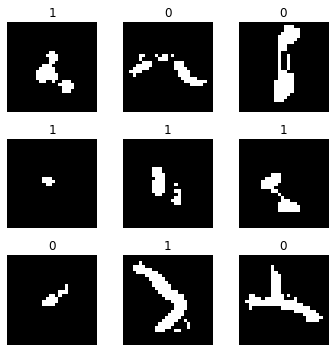

In [22]:
dls.show_batch(figsize=(5,5),anatomical_plane=0)

In [23]:
dls.train_ds.items

,filePath,label
206,../data/vesselmnist3d/train/56.nii.gz,1
128,../data/vesselmnist3d/train/278.nii.gz,0
40,../data/vesselmnist3d/train/190.nii.gz,0
247,../data/vesselmnist3d/train/97.nii.gz,1
270,../data/vesselmnist3d/train/120.nii.gz,1
...,...,...
98,../data/vesselmnist3d/train/248.nii.gz,0
7,../data/vesselmnist3d/train/157.nii.gz,0
78,../data/vesselmnist3d/train/228.nii.gz,0
20,../data/vesselmnist3d/train/170.nii.gz,0


In [24]:
from monai.networks.nets import Classifier
from monai.losses import FocalLoss
from torch.nn import CrossEntropyLoss

# loss_func = CustomLoss(loss_func=CrossEntropyLoss())

model = Classifier(in_shape=[1, 28, 28, 28], classes=2, 
    channels=(8, 16, 32, 64, 128), strides=(2,2,2,2))
learn = Learner(dls, model, metrics=accuracy)
# learn.loss_func = loss_func

In [25]:
learn.fit_one_cycle(10)

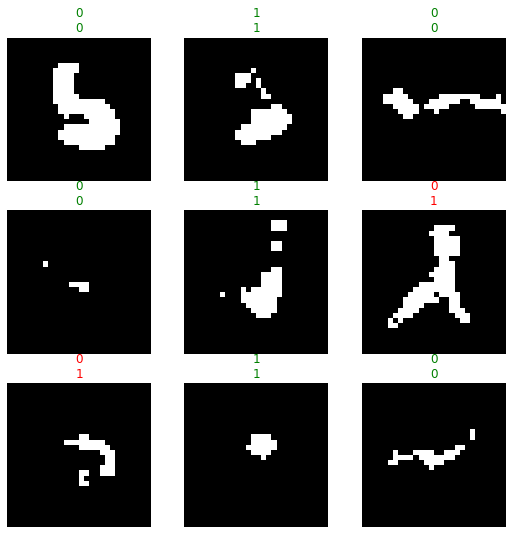

In [26]:
learn.show_results(anatomical_plane=0)

In [27]:
preds, target = learn.tta()

In [28]:
accuracy(preds, target)

TensorBase(0.6833)

In [29]:
# test_df = createDataFrame(dir, "test", affine)   
test_df = getDataFrame(dir, "test")

In [30]:
test_df

,filePath,label
0,../data/vesselmnist3d/test/0.nii.gz,1
1,../data/vesselmnist3d/test/1.nii.gz,1
2,../data/vesselmnist3d/test/2.nii.gz,1
3,../data/vesselmnist3d/test/3.nii.gz,1
4,../data/vesselmnist3d/test/4.nii.gz,1
...,...,...
377,../data/vesselmnist3d/test/377.nii.gz,0
378,../data/vesselmnist3d/test/378.nii.gz,0
379,../data/vesselmnist3d/test/379.nii.gz,0
380,../data/vesselmnist3d/test/380.nii.gz,0


In [31]:
test_dls = dblock.dataloaders(test_df, bs=32)

In [32]:
interp = ClassificationInterpretation.from_learner(learn)

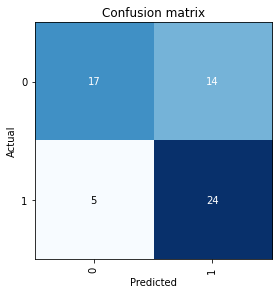

In [33]:
interp.plot_confusion_matrix()

In [34]:
interp.print_classification_report()

              precision    recall  f1-score   support

           0       0.77      0.55      0.64        31
           1       0.63      0.83      0.72        29

    accuracy                           0.68        60
   macro avg       0.70      0.69      0.68        60
weighted avg       0.70      0.68      0.68        60

